## Human in loop (Custom code)

### Configure the model

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

### Initializing Tavily and multiply tool

In [2]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

@tool
def search(query:str):
    """search the web for a query and return the results"""
    tavily_tool = TavilySearchResults()
    result = tavily_tool.invoke(query)
    return f"Result for {query} is: \n{result}"

### Tool binding and mapping

In [3]:
tools = [multiply, search]
llm_with_tools = llm.bind_tools(tools)
result=llm_with_tools.invoke("what is current gdp of india?")
print(result.content)
print(result.tool_calls)


[{'name': 'search', 'args': {'query': 'current GDP of India'}, 'id': '33akhphyh', 'type': 'tool_call'}]


In [4]:
result.tool_calls[0]["name"]

'search'

In [5]:
result.tool_calls[0]["args"]

{'query': 'current GDP of India'}

In [6]:
tool_mapping = {tool.name:tool for tool in tools}
tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001E495836020>),
 'search': StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001E4958BFD80>)}

In [7]:
tool_mapping["search"]

StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001E4958BFD80>)

In [13]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """State for the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

def invoke_model(state:AgentState):
    messages = state["messages"]
    question = messages[-1]
    result = llm_with_tools.invoke(question)
    return {"messages": [result]}

def router(state:AgentState):
    tool_calls = state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool"  #key_name
    else:
        return "end"  #key_name
    
def invoke_tools(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")

    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

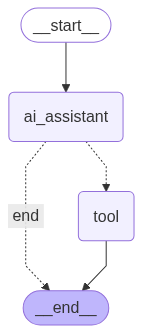

In [14]:
from langgraph.graph import StateGraph, START,END

graph = StateGraph(AgentState)
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tools)
graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool", ##with the key tool which value is associated <tool>
                                "end":END
                            }
                            )

graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
app.invoke({"messages":["What is the multiplication of 5 and 20?"]})

Seleted tool: multiply


{'messages': ['What is the multiplication of 5 and 20?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'd0gxp0849', 'function': {'arguments': '{"x":5,"y":20}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 280, 'prompt_tokens': 177, 'total_tokens': 457, 'completion_time': 1.427465864, 'prompt_time': 0.01163795, 'queue_time': 0.057702025, 'total_time': 1.439103814}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--93be5f67-b111-49d9-bed3-bf394d994d9e-0', tool_calls=[{'name': 'multiply', 'args': {'x': 5, 'y': 20}, 'id': 'd0gxp0849', 'type': 'tool_call'}], usage_metadata={'input_tokens': 177, 'output_tokens': 280, 'total_tokens': 457}),
  100]}

In [ ]:
# human replied with yes
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search


C:\Users\aayushisharma\AppData\Local\Temp\ipykernel_24444\3815303541.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults()


{'messages': ['What is the current gdp of the india?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'venx7g4qk', 'function': {'arguments': '{"query":"current GDP of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 176, 'total_tokens': 305, 'completion_time': 0.55184762, 'prompt_time': 0.01162192, 'queue_time': 0.057482294999999996, 'total_time': 0.56346954}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--44b7491b-aa95-4ece-a677-50c7220d9cf8-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of India'}, 'id': 'venx7g4qk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 129, 'total_tokens': 305}),
  'Result for current GDP of India is: \n[{\'title\': \'World GDP Ranking 2025 List - ClearTax\', \'url\': \'https://cleartax.in/s/world-gdp-ranking-list\

In [17]:
# human replied with no
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search
web search discarded by the user. exiting gracefully


Exception: Web search discarded by the user.

## Human in loop (with inbuilt langgraph functions)

### creating workflow and using interupt before to ask for human input

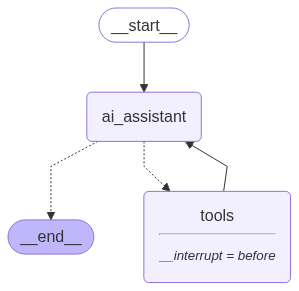

In [19]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

tool_node = ToolNode(tools)
llm_with_tools=llm.bind_tools(tools)

def ai_assistant(state:AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

memory = MemorySaver()

graph_build = StateGraph(AgentState)
graph_build.add_node("ai_assistant", ai_assistant)
graph_build.add_node("tools",tool_node)
graph_build.set_entry_point("ai_assistant")
graph_build.add_conditional_edges("ai_assistant",
                                    tools_condition,
                                    )
graph_build.add_edge("tools", "ai_assistant")
app2=graph_build.compile(checkpointer=memory,interrupt_before=["tools"])

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

### Initialize memory thread and chk for output

In [20]:
config={"configurable":{"thread_id":"1"}}
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the china?")]},config=config)
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361})]}

### Capture the snapshot of the state so we will resume from here

In [21]:
snapshot=app2.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'chec

In [22]:
snapshot.next

('tools',)

In [24]:
last_message=snapshot.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361})

In [25]:
tool_details=last_message.tool_calls
tool_details

[{'name': 'search',
  'args': {'query': 'current GDP of China'},
  'id': 'tn3j4fjg5',
  'type': 'tool_call'}]

### taking human input and resuming from last state

In [26]:
if tool_details[0]["name"]== "search":
    user_input=input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}?").lower()
    if user_input=="no":
        print("web tool discarded")
        raise Exception("Web tool discarded by the user.")
    else:
        response=app2.invoke(None,config)  #none means resume the last state or resume the process
        print(response)
else:
    response=app2.invoke(None,config)
    print(response)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361}), ToolMessage(content='Result for current GDP of China is: \n[{\'title\': \'China - GDP - 

In [37]:
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

In [28]:
snapshot=app2.get_state(config)
snapshot.next

('tools',)

In [29]:
last_message=snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of Japan'},
  'id': 'aerdw3p8q',
  'type': 'tool_call'}]

In [31]:
tool_call_id=last_message.tool_calls[0]["id"]
tool_call_id

'aerdw3p8q'

### appending custom messages in tool message and ai message

In [32]:
from langchain_core.messages import AIMessage,ToolMessage

new_message=[
    ToolMessage(content="according to the latest data 4.1 trillion USD",tool_call_id=tool_call_id),
    AIMessage(content="GDP is 4.1 Trillion USD.")
    
]

app2.update_state(config, 
                  {
                      "messages":new_message
                   }
                  )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0558b6-fbdf-6ec6-8007-1dc0c68ca1a0'}}

In [33]:
app2.get_state(config).values["messages"][-1]

AIMessage(content='GDP is 4.1 Trillion USD.', additional_kwargs={}, response_metadata={})

In [34]:
app2.invoke(None,config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361}),
  ToolMessage(content='Result for current GDP of China is: \n[{\'title\': \'China - GD

In [35]:
app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tn3j4fjg5', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 185, 'prompt_tokens': 176, 'total_tokens': 361, 'completion_time': 0.710125217, 'prompt_time': 0.02157076, 'queue_time': 0.058972199999999995, 'total_time': 0.731695977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d81dcd0e-04f6-47b9-b6a4-cafc35af1b57-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'tn3j4fjg5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 185, 'total_tokens': 361}),
  ToolMessage(content='Result for current GDP of China is: \n[{\'title\': \'China - GD